<style  type="text/css"> 
</style>

<b><center>
<span style="font-size: 24pt; line-height: 1.2">
COMS W4111-002/V002 (Spring 2022)<br>Introduction to Databases
</span>
</center></b>
</span><br>
<p>
<i><center>
<span style="font-size: 20pt; line-height: 1.2">
Homework 3c: Programming<br>
</span>
</center></i><br><br>

# Overview

- There are three parts to HW 3:
    - ```3a```: Written questions
    - ```3b:``` A set of common practical tasks.
    - ```3c:``` Programming and Non-Programming track specific tasks.
    
    
- This notebook define part ```3c Programming.``` 

# Programming Task

## Resource Model/Paths

- You will extend the REST endpoint that you developed for HW2.


- You will implement the following resource model.


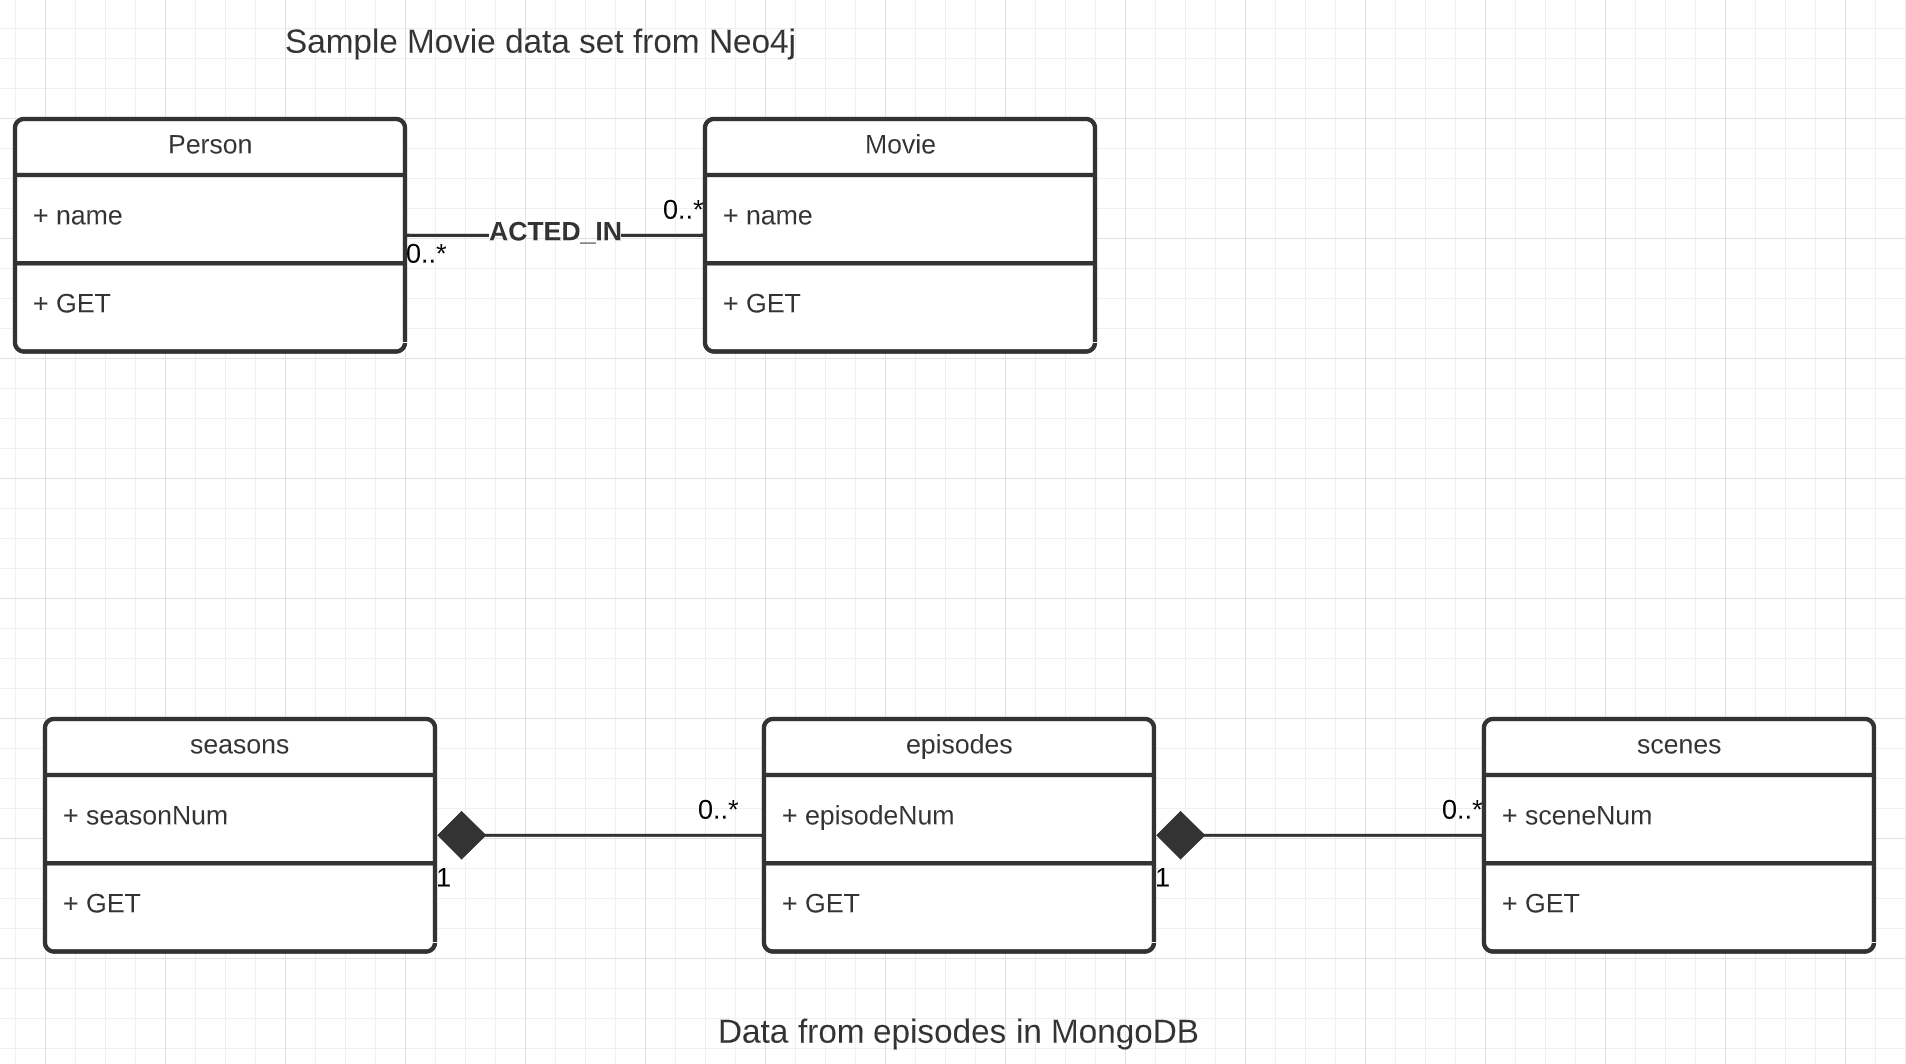

- This means you REST application should implement the following paths:
    - ```/seasons```
    - ```/seasons/{seasonNum}```
    - ```/seasons/{seasonNum}/episodes```
    - ```/seasons/seasonNum/episodes/{episodeNum}```
    - ```/seasons/seasonNum/episodes/{episodeNum}/scenes```
    - ```/seasons/seasonNum/episodes/{episodeNum}/scenes/sceneNum```
    - ```/person```
    - ```/movie```
    - ```/person/{name}/acted_in```
    
    
- Given the fact that there is "no data" in the MongoDB/JSON data for ```seasons,``` the application should simply return a list containing the episode titles and air dates.
    
    

- You need to implement query parameter processing only for:
    - ```/movies```
    - ```/episodes```
    
    
- You do not have to implement any form of project.

## Suggestion

The suggested implement structure is the following:


- ```application.py``` has functions for each of the paths and calls a "resource" implementation.


- You implement a ```xxx_resource.py``` for each of the "resources." Specifically,
    - ```seasons_resource.py```
    - ```episodes_resource.py```
    - ```scenes_resource.py```
    - ```person_resource.py```
    - ```movie_resource.py```
    
    
- Implement two data services the the above services use to interact with the backend databases, specifically:
    - ```mongodb_data_service.py```
    - ```neo4j_data_service.py```

## application.py

```python
from flask import Flask, Response, request
from flask_cors import CORS
import json
from datetime import datetime
from resources.seasons_resource import Seasons
from resources.episodes_resource import Episodes
from resources.scenes_resource import Scenes
from resources.movie_resource import Movie
from resources.person_resource import Person

import rest_utils

app = Flask(__name__)
CORS(app)

def default_json(t):
    return f'{t}'

##################################################################################################################

@app.route('/')
def hello_world():
    return '<u>Hello World!</u>'

@app.route("/seasons", methods=["GET"])
def get_seasons():
    msg = seasons.get_all()
    rsp = Response(json.dumps(msg,default=default_json), status=200, content_type="application/json")
    return rsp

@app.route("/seasons/<seasonNum>", methods=["GET"])
def get_season_by_number(seasonNum):
    msg = seasons.get_by_number(int(seasonNum))
    rsp = Response(json.dumps(msg,default=default_json), status=200, content_type="application/json")
    return rsp

@app.route("/seasons/<seasonNum>/episodes", methods=["GET"])
def get_episodes(seasonNum):
    request_inputs = rest_utils.RESTContext(request)

    if request_inputs.args is None:
        request_inputs.args = {}

    if request_inputs.fields is None:
        request_inputs.fields = {}
    else:
        request_inputs.fields = dict.fromkeys(request_inputs.fields,1)

    if request_inputs.limit is None:
        request_inputs.limit = 0

    if request_inputs.offset is None:
        request_inputs.offset = 0

    if request_inputs.order_by is None:
        request_inputs.order_by = {}



    msg = episodes.get_all(int(seasonNum),
                            template=request_inputs.args,
                            field_list=request_inputs.fields,
                            limit=request_inputs.limit,
                            offset=request_inputs.offset,
                            order_by=request_inputs.order_by)
    rsp = Response(json.dumps(msg,default=default_json), status=200, content_type="application/json")
    return rsp

@app.route("/seasons/<seasonNum>/episodes/<episodeNum>", methods=["GET"])
def get_episode_by_number(seasonNum,episodeNum):
    msg = episodes.get_by_number(int(seasonNum),int(episodeNum))
    rsp = Response(json.dumps(msg,default=default_json), status=200, content_type="application/json")
    return rsp

@app.route("/seasons/<seasonNum>/episodes/<episodeNum>/scenes", methods=["GET"])
def get_scenes(seasonNum,episodeNum):
    msg = scenes.get_all(int(seasonNum),int(episodeNum))
    rsp = Response(json.dumps(msg,default=default_json), status=200, content_type="application/json")
    return rsp

@app.route("/seasons/<seasonNum>/episodes/<episodeNum>/scenes/<sceneNum>", methods=["GET"])
def get_scene_by_number(seasonNum,episodeNum,sceneNum):
    msg = scenes.get_by_number(int(seasonNum),int(episodeNum),int(sceneNum))
    rsp = Response(json.dumps(msg,default=default_json), status=200, content_type="application/json")
    return rsp

@app.route("/movie", methods=["GET"])
def get_movie():

    request_inputs = rest_utils.RESTContext(request)

    if request_inputs.args is None:
        request_inputs.args = {}

    if request_inputs.fields is None:
        request_inputs.fields = {}
    else:
        request_inputs.fields = dict.fromkeys(request_inputs.fields,1)

    if request_inputs.limit is None:
        request_inputs.limit = 0

    if request_inputs.offset is None:
        request_inputs.offset = 0

    if request_inputs.order_by is None:
        request_inputs.order_by = {}

    msg = movie.get_all(template=request_inputs.args,
                        field_list=request_inputs.fields,
                        limit=request_inputs.limit,
                        offset=request_inputs.offset,
                        order_by=request_inputs.order_by)
    rsp = Response(msg, status=200, content_type="application/json")
    return rsp

@app.route("/person", methods=["GET"])
def get_person():
    msg = person.get_all()
    rsp = Response(msg, status=200, content_type="application/json")
    return rsp

@app.route("/person/<name>/acted_in", methods=["GET"])
def get_acted_in(name):
    msg = person.get_movie(name)
    rsp = Response(msg, status=200, content_type="application/json")
    return rsp



if __name__ == '__main__':
    seasons = Seasons()
    episodes = Episodes()
    scenes = Scenes()
    movie = Movie()
    person = Person()
    app.run(host="0.0.0.0", port=5003)

```

## services/mongodb_data_service.py

```python
import sys
import pymongo
import config

class MongoDB():

   def get_client(self):
      client = pymongo.MongoClient(
       config.mongodb_url
      )
      db = client.test
      return client

   def __init__(self,dbname,tablename):
      self.client = self.get_client()
      self.dbname = dbname
      self.tablename = tablename
      self.table = self.client[self.dbname][self.tablename]

   def query(self,template={},field_list={},limit=0,offset=0,order_by={}):
      field_list['_id'] = 0
      q = self.table.find(template,field_list)
      if len(order_by)>0:
         q = q.sort(order_by,1)
      q = q.skip(int(offset)).limit(int(limit))
      return q
```

## services/neo4j_data_service.py

```python
import config
import pandas as pd

from py2neo import data, Graph, NodeMatcher, Node, Relationship, RelationshipMatcher
"""
See https://py2neo.org/v4/
"""

"""
NOTE:
    1. I did some basic testing, debugging, etc. but there may be errors.
    2. You can complain about the errors if you want but my response will be, "No Template for You!"
"""


import uuid


class GotGraph(object):
    """
    This object provides a set of helper methods for creating and retrieving nodes and relationships from
    a Neo4j database holding information about players, teams, fans, comments and their relationships.
    """

    # Note:
    # I tend to avoid object mapping frameworks. Object mapping frameworks are fun in the beginning
    # but tend to be annoying after a while. So, I did not create types Player, Team, etc.
    #


    # Connects to the DB and sets a Graph instance variable.
    # Also creates a NodeMatcher and RelationshipMatcher, which are a py2neo framework classes.
    def __init__(self,  url, auth):

        self._graph = Graph(url,
                            auth=auth
                            )
        self._node_matcher = NodeMatcher(self._graph)
        self._relationship_matcher = RelationshipMatcher(self._graph)

    def run_q(self, qs, args):
        """

        :param qs: Query string that may have {} slots for parameters.
        :param args: Dictionary of parameters to insert into query string.
        :return:  Result of the query, which executes as a single, standalone transaction.
        """
        try:
            tx = self._graph.auto(readonly=False)
            result = self._graph.run(qs, args)
            return result
        except Exception as e:
            print("Run exaception = ", e)

    def run_match(self, labels=None, properties=None):
        """
        Uses a NodeMatcher to find a node matching a "template."
        :param labels: A list of labels that the node must have.
        :param properties: A dictionary of {property_name: property_value} defining the template that the
            node must match.
        :return: An array of Node objects matching the pattern.
        """
        #ut.debug_message("Labels = ", labels)
        #ut.debug_message("Properties = ", json.dumps(properties))

        if labels is not None and properties is not None:
            result = self._node_matcher.match(labels, **properties)
        elif labels is not None and properties is None:
            result = self._node_matcher.match(labels)
        elif labels is None and properties is not None:
            result = self._node_matcher.match(**properties)
        else:
            raise ValueError("Invalid request. Labels and properties cannot both be None.")

        # Convert NodeMatch data into a simple list of Nodes.
        full_result = []
        for r in result:
            full_result.append(r)

        return full_result

    def find_nodes_by_template(self, tmp):
        """

        :param tmp: A template defining the label and properties for Nodes to return. An
         example is { "label": "Fan", "template" { "last_name": "Ferguson", "first_name": "Donald" }}
        :return: A list of Nodes matching the template.
        """
        labels = tmp.get('label', None)
        props = tmp.get("template", None)
        result = self.run_match(labels=labels, properties=props)
        return result

    def create_node(self, label, **kwargs):
        n = Node(label, **kwargs)
        tx = self._graph.begin(autocommit=True)
        tx.create(n)
        return n

class Neo4j():

   def get_graph(self):

      g = GotGraph(url=config.neo_url,
                 auth = config.neo_auth
                 )
      return g


   def __init__(self):
      self.graph = self.get_graph()

   def query(self,table_id="m",template={},field_list={},limit=0,offset=0,order_by=None):

      table_text = {
                  "m" : "m:Movie",
                  "p" : "p:Person",
                  "r" : "(p:Person)-[r:ACTED_IN]->(m:Movie)"
               }

      cond_id = "p" if table_id == "r" else table_id

      conditions_text = " AND ".join([f"{cond_id}." + " = ".join(x) for x in template.items()]) if len(template) > 0 else "TRUE"

      order_text = f"\nORDER BY {table_id}.{order_by}" if order_by is not None else ""

      offset_text = f"\nSKIP {offset}" if int(offset)>0 else ""

      limit_text = f"\nLIMIT {limit}" if int(limit)>0 else ""

      field_dict = {
                     "m" : "m.title,m.released,m.tagline",
                     "p" : "p.name,p.born",
                     "r" : "m.title,m.released,m.tagline"
                   }

      field_text = ",".join([f"{table_id}." + x for x in field_list.keys()]) if len(field_list)>0 else field_dict[table_id]



      cypher_q = f"""
          match
              ({table_text[table_id]})
          WHERE {conditions_text}
          return {field_text}{order_text}{offset_text}{limit_text}
      """

      res = self.graph.run_q(cypher_q, None)

      df = pd.DataFrame(res)

      return df.to_json(orient='values')
```

## resources/seasons_resource.py

```python
import pymysql
import json
from services.mongodb_data_service import MongoDB


class Seasons():

    def __init__(self):
        self.db_schema = 'GoT'
        self.db_table = 'episodes'
        self.mongodb = MongoDB(self.db_schema,self.db_table)


    def get_all(self):

        template = {}
        field_list = {'episodeTitle': 1, 'episodeAirDate': 1,'_id':0 }
        limit = 0
        offset = 0

        result = self.mongodb.query(template,field_list,limit,offset)
        return list(result)

    def get_by_number(self,seasonNum):
        template = {'seasonNum':seasonNum}
        field_list = {}
        limit = 0
        offset = 0

        result = self.mongodb.query(template,field_list,limit,offset)
        return list(result)

if __name__ == "__main__":

    seasons = Seasons()

    all_season = seasons.get_all()
    print(json.dumps(all_season, indent=2))


```

## resources/episodes_resource.py

```python
import pymysql
import json
from services.mongodb_data_service import MongoDB


class Episodes():

    def __init__(self):
        self.db_schema = 'GoT'
        self.db_table = 'episodes'
        self.mongodb = MongoDB(self.db_schema,self.db_table)


    def get_all(self,seasonNum,template={},field_list={},limit=0,offset=0,order_by={}):

        template['seasonNum'] = seasonNum

        result = self.mongodb.query(template=template,field_list=field_list,limit=limit,offset=offset,order_by=order_by)
        return list(result)

    def get_by_number(self,seasonNum,episodeNum):
        template = {'seasonNum':seasonNum,'episodeNum':episodeNum}
        field_list = {}
        limit = 0
        offset = 0

        result = self.mongodb.query(template,field_list,limit,offset)
        return list(result)

if __name__ == "__main__":

    episodes = Episodes()

    all_episodes = episodes.get_all(2)
    print(json.dumps(all_episodes, indent=2))


```

## resources/scenes_resource.py

```python

import pymysql
import json
from services.mongodb_data_service import MongoDB


class Scenes():

    def __init__(self):
        self.db_schema = 'GoT'
        self.db_table = 'episodes'
        self.mongodb = MongoDB(self.db_schema,self.db_table)


    def get_all(self,seasonNum,episodeNum):

        template = {'seasonNum':seasonNum,'episodeNum':episodeNum}
        field_list = {'_id':0, 'scenes':1}
        limit = 0
        offset = 0

        result = self.mongodb.query(template,field_list,limit,offset)
        return result.next()['scenes']

    def get_by_number(self,seasonNum,episodeNum,sceneNum):
        
        template = {'seasonNum':seasonNum,'episodeNum':episodeNum}
        field_list = {'_id':0, 'scenes':1}
        limit = 0
        offset = 0

        result = self.mongodb.query(template,field_list,limit,offset)
        return result.next()['scenes'][sceneNum]

if __name__ == "__main__":

    scenes = Scenes()

    all_scenes = scenes.get_all(2,5)
    print(json.dumps(all_scenes, indent=2))


```

## resources/person_resource.py

```python
import pymysql
import json
from services.neo4j_data_service import Neo4j


class Person():

    def __init__(self):
        self.neo4j = Neo4j()


    def get_all(self):


        result = self.neo4j.query(table_id="p")
        return list(result)

    def get_movie(self,person):
        sp = "\""
        template = {'name':sp+person+sp}

        result = self.neo4j.query(table_id="r",template=template)
        return list(result)

if __name__ == "__main__":

    person = Person()

    all_person = person.get_all()
    print(json.dumps(all_person, indent=2))


```

## resources/movie_resource.py

```python
import pymysql
import json
from services.neo4j_data_service import Neo4j


class Movie():

    def __init__(self):
        self.neo4j = Neo4j()


    def get_all(self,template={},field_list={},limit=0,offset=0,order_by={}):

        result = self.neo4j.query(table_id='m',template=template,field_list=field_list,limit=limit,offset=offset,order_by=order_by)
        return list(result)

if __name__ == "__main__":

    movie = Movie()

    all_movie = movie.get_all()
    print(json.dumps(all_episodes, indent=2))


```

## Usage

```python
python application.py
```

Check if the IP Address = 192.168.86.200:5003

# Tests

- You will use ```requests``` to test your paths below.



In [1]:
import requests
# Tests
#
# Have a cell for each test below.
#

ip = "http://192.168.86.200:5003"

In [2]:
# Testing /seasons
url = ip + "/seasons"
res = requests.get(url)
res = res.json()
res

[{'episodeTitle': 'Winter Is Coming', 'episodeAirDate': '2011-04-17'},
 {'episodeTitle': 'The Kingsroad', 'episodeAirDate': '2011-04-24'},
 {'episodeTitle': 'Lord Snow', 'episodeAirDate': '2011-05-01'},
 {'episodeTitle': 'Cripples, Bastards, and Broken Things',
  'episodeAirDate': '2011-05-08'},
 {'episodeTitle': 'The Wolf and the Lion', 'episodeAirDate': '2011-05-15'},
 {'episodeTitle': 'A Golden Crown', 'episodeAirDate': '2011-05-22'},
 {'episodeTitle': 'You Win or You Die', 'episodeAirDate': '2011-05-29'},
 {'episodeTitle': 'The Pointy End', 'episodeAirDate': '2011-06-05'},
 {'episodeTitle': 'Baelor', 'episodeAirDate': '2011-06-12'},
 {'episodeTitle': 'Fire and Blood', 'episodeAirDate': '2011-06-19'},
 {'episodeTitle': 'The North Remembers', 'episodeAirDate': '2012-04-01'},
 {'episodeTitle': 'The Night Lands', 'episodeAirDate': '2012-04-08'},
 {'episodeTitle': 'What Is Dead May Never Die',
  'episodeAirDate': '2012-04-15'},
 {'episodeTitle': 'Garden of Bones', 'episodeAirDate': '201

In [3]:
# Testing /seasons/<season_num>
url = ip + "/seasons/2"
res = requests.get(url)
res = res.json()
res

[{'seasonNum': 2,
  'episodeNum': 1,
  'episodeTitle': 'The North Remembers',
  'episodeLink': '/title/tt1971833/',
  'episodeAirDate': '2012-04-01',
  'episodeDescription': "Tyrion arrives at King's Landing to take his father's place as Hand of the King. Stannis Baratheon plans to take the Iron Throne for his own. Robb tries to decide his next move in the war. The Night's Watch arrive at the house of Craster.",
  'openingSequenceLocations': ["King's Landing",
   'Dragonstone',
   'Winterfell',
   'The Wall',
   'Vaes Dothrak'],
  'scenes': [{'sceneStart': '0:02:29',
    'sceneEnd': '0:03:08',
    'location': 'The Crownlands',
    'subLocation': "King's Landing",
    'characters': [{'name': 'Sandor Clegane'},
     {'name': 'Joffrey Baratheon', 'title': 'King'},
     {'name': 'Sansa Stark'},
     {'name': 'Meryn Trant'}]},
   {'sceneStart': '0:03:08',
    'sceneEnd': '0:03:12',
    'location': 'The Crownlands',
    'subLocation': "King's Landing",
    'characters': []},
   {'sceneStart'

In [4]:
# Testing /seasons<season_num>/episodes
url = ip + "/seasons/2/episodes"
res = requests.get(url)
res = res.json()
res

[{'seasonNum': 2,
  'episodeNum': 1,
  'episodeTitle': 'The North Remembers',
  'episodeLink': '/title/tt1971833/',
  'episodeAirDate': '2012-04-01',
  'episodeDescription': "Tyrion arrives at King's Landing to take his father's place as Hand of the King. Stannis Baratheon plans to take the Iron Throne for his own. Robb tries to decide his next move in the war. The Night's Watch arrive at the house of Craster.",
  'openingSequenceLocations': ["King's Landing",
   'Dragonstone',
   'Winterfell',
   'The Wall',
   'Vaes Dothrak'],
  'scenes': [{'sceneStart': '0:02:29',
    'sceneEnd': '0:03:08',
    'location': 'The Crownlands',
    'subLocation': "King's Landing",
    'characters': [{'name': 'Sandor Clegane'},
     {'name': 'Joffrey Baratheon', 'title': 'King'},
     {'name': 'Sansa Stark'},
     {'name': 'Meryn Trant'}]},
   {'sceneStart': '0:03:08',
    'sceneEnd': '0:03:12',
    'location': 'The Crownlands',
    'subLocation': "King's Landing",
    'characters': []},
   {'sceneStart'

In [5]:
# Testing /seasons<season_num>/episodes (with query processing - 1)
url = ip + "/seasons/2/episodes"
res = requests.get(url,params={"episodeAirDate" : "2012-04-15",
                               "fields" : 'seasonNum,episodeNum,episodeTitle,episodeLink,episodeAirDate'
                              })
res = res.json()
res

[{'seasonNum': 2,
  'episodeNum': 3,
  'episodeTitle': 'What Is Dead May Never Die',
  'episodeLink': '/title/tt2070135/',
  'episodeAirDate': '2012-04-15'}]

In [6]:
# Testing /seasons<season_num>/episodes (with query processing - 2)
url = ip + "/seasons/2/episodes"
res = requests.get(url,params={"order_by" : "episodeTitle",
                               "fields" : 'episodeNum,episodeTitle,episodeAirDate',
                               "limit" : 5,
                               "offset" : 3
                              })
res = res.json()
res

[{'episodeNum': 5,
  'episodeTitle': 'The Ghost of Harrenhal',
  'episodeAirDate': '2012-04-29'},
 {'episodeNum': 2,
  'episodeTitle': 'The Night Lands',
  'episodeAirDate': '2012-04-08'},
 {'episodeNum': 1,
  'episodeTitle': 'The North Remembers',
  'episodeAirDate': '2012-04-01'},
 {'episodeNum': 6,
  'episodeTitle': 'The Old Gods and the New',
  'episodeAirDate': '2012-05-06'},
 {'episodeNum': 8,
  'episodeTitle': 'The Prince of Winterfell',
  'episodeAirDate': '2012-05-20'}]

In [7]:
# Testing /seasons<season_num>/episodes/<episode_num>
url = ip + "/seasons/2/episodes/5"
res = requests.get(url)
res = res.json()
res

[{'seasonNum': 2,
  'episodeNum': 5,
  'episodeTitle': 'The Ghost of Harrenhal',
  'episodeLink': '/title/tt2074658/',
  'episodeAirDate': '2012-04-29',
  'episodeDescription': "Tyrion investigates a secret weapon that King Joffrey plans to use against Stannis. Meanwhile, as a token for saving his life, Jaqen H'ghar offers to kill three people that Arya chooses.",
  'openingSequenceLocations': ["King's Landing",
   'Harrenhal',
   'Pyke',
   'Winterfell',
   'The Wall',
   'Qarth'],
  'scenes': [{'sceneStart': '0:01:54',
    'sceneEnd': '0:05:17',
    'location': 'The Stormlands',
    'subLocation': "Storm's End",
    'altLocation': "Renly Baratheon's Camp",
    'characters': [{'name': 'Catelyn Stark'},
     {'name': 'Brienne of Tarth'},
     {'name': 'Renly Baratheon',
      'title': 'King',
      'alive': False,
      'mannerOfDeath': 'Shadow baby',
      'killedBy': ['Melisandre']}]},
   {'sceneStart': '0:05:17',
    'sceneEnd': '0:05:34',
    'location': 'The Stormlands',
    'subL

In [8]:
# Testing /seasons<season_num>/episodes/<episode_num>/scenes
url = ip + "/seasons/2/episodes/5/scenes"
res = requests.get(url)
res = res.json()
res

[{'sceneStart': '0:01:54',
  'sceneEnd': '0:05:17',
  'location': 'The Stormlands',
  'subLocation': "Storm's End",
  'altLocation': "Renly Baratheon's Camp",
  'characters': [{'name': 'Catelyn Stark'},
   {'name': 'Brienne of Tarth'},
   {'name': 'Renly Baratheon',
    'title': 'King',
    'alive': False,
    'mannerOfDeath': 'Shadow baby',
    'killedBy': ['Melisandre']}]},
 {'sceneStart': '0:05:17',
  'sceneEnd': '0:05:34',
  'location': 'The Stormlands',
  'subLocation': "Storm's End",
  'altLocation': "Renly Baratheon's Camp",
  'characters': [{'name': 'Petyr Baelish'}]},
 {'sceneStart': '0:05:34',
  'sceneEnd': '0:08:03',
  'location': 'The Stormlands',
  'subLocation': "Storm's End",
  'altLocation': "Renly Baratheon's Camp",
  'characters': [{'name': 'Loras Tyrell'},
   {'name': 'Renly Baratheon', 'title': 'King', 'alive': False},
   {'name': 'Margaery Tyrell'},
   {'name': 'Petyr Baelish'}]},
 {'sceneStart': '0:08:03',
  'sceneEnd': '0:08:07',
  'location': 'The Crownlands',
 

In [9]:
# Testing /seasons<season_num>/episodes/<episode_num>/scenes/<scene_num>
# Treating scenes like a 0 indexed list
url = ip + "/seasons/2/episodes/5/scenes/3"
res = requests.get(url)
res = res.json()
res

{'sceneStart': '0:08:03',
 'sceneEnd': '0:08:07',
 'location': 'The Crownlands',
 'subLocation': "King's Landing",
 'characters': [{'name': 'Myrcella Baratheon'}]}

In [10]:
# Testing /person
url = ip + "/person"
res = requests.get(url)
res = res.json()
res

[['Keanu Reeves', 1964.0],
 ['Carrie-Anne Moss', 1967.0],
 ['Laurence Fishburne', 1961.0],
 ['Hugo Weaving', 1960.0],
 ['Lilly Wachowski', 1967.0],
 ['Lana Wachowski', 1965.0],
 ['Joel Silver', 1952.0],
 ['Emil Eifrem', 1978.0],
 ['Charlize Theron', 1975.0],
 ['Al Pacino', 1940.0],
 ['Taylor Hackford', 1944.0],
 ['Tom Cruise', 1962.0],
 ['Jack Nicholson', 1937.0],
 ['Demi Moore', 1962.0],
 ['Kevin Bacon', 1958.0],
 ['Kiefer Sutherland', 1966.0],
 ['Noah Wyle', 1971.0],
 ['Cuba Gooding Jr.', 1968.0],
 ['Kevin Pollak', 1957.0],
 ['J.T. Walsh', 1943.0],
 ['James Marshall', 1967.0],
 ['Christopher Guest', 1948.0],
 ['Rob Reiner', 1947.0],
 ['Aaron Sorkin', 1961.0],
 ['Kelly McGillis', 1957.0],
 ['Val Kilmer', 1959.0],
 ['Anthony Edwards', 1962.0],
 ['Tom Skerritt', 1933.0],
 ['Meg Ryan', 1961.0],
 ['Tony Scott', 1944.0],
 ['Jim Cash', 1941.0],
 ['Renee Zellweger', 1969.0],
 ['Kelly Preston', 1962.0],
 ["Jerry O'Connell", 1974.0],
 ['Jay Mohr', 1970.0],
 ['Bonnie Hunt', 1961.0],
 ['Regina K

In [11]:
# Testing /person/<person_name>/acted_in
url = ip + "/person/Keanu Reeves/acted_in"
res = requests.get(url)
res = res.json()
res

[["Something's Gotta Give", 2003, None],
 ['The Replacements',
  2000,
  'Pain heals, Chicks dig scars... Glory lasts forever'],
 ['Johnny Mnemonic',
  1995,
  'The hottest data on earth. In the coolest head in town'],
 ["The Devil's Advocate", 1997, 'Evil has its winning ways'],
 ['The Matrix Revolutions',
  2003,
  'Everything that has a beginning has an end'],
 ['The Matrix Reloaded', 2003, 'Free your mind'],
 ['The Matrix', 1999, 'Welcome to the Real World']]

In [12]:
# Testing /movie
url = ip + "/movie"
res = requests.get(url)
res = res.json()
res

[['The Matrix', 1999, 'Welcome to the Real World'],
 ['The Matrix Reloaded', 2003, 'Free your mind'],
 ['The Matrix Revolutions',
  2003,
  'Everything that has a beginning has an end'],
 ["The Devil's Advocate", 1997, 'Evil has its winning ways'],
 ['A Few Good Men',
  1992,
  "In the heart of the nation's capital, in a courthouse of the U.S. government, one man will stop at nothing to keep his honor, and one will stop at nothing to find the truth."],
 ['Top Gun', 1986, 'I feel the need, the need for speed.'],
 ['Jerry Maguire', 2000, 'The rest of his life begins now.'],
 ['Stand By Me',
  1986,
  "For some, it's the last real taste of innocence, and the first real taste of life. But for everyone, it's the time that memories are made of."],
 ['As Good as It Gets',
  1997,
  'A comedy from the heart that goes for the throat.'],
 ['What Dreams May Come',
  1998,
  'After life there is more. The end is just the beginning.'],
 ['Snow Falling on Cedars', 1999, 'First loves last. Forever.']

In [13]:
# Testing /movie (with query processing - 1)
url = ip + "/movie"
res = requests.get(url,params={"order_by" : "released",
                               "fields" : 'title,released',
                               "limit" : 10,
                               "offset" : 20
                              })
res = res.json()
res

[['Snow Falling on Cedars', 1999],
 ['Bicentennial Man', 1999],
 ['The Matrix', 1999],
 ['Jerry Maguire', 2000],
 ['Cast Away', 2000],
 ['The Replacements', 2000],
 ['The Matrix Revolutions', 2003],
 ['The Matrix Reloaded', 2003],
 ["Something's Gotta Give", 2003],
 ['The Polar Express', 2004]]

In [14]:
# Testing /movie (with query processing - 2)
url = ip + "/movie"
res = requests.get(url,params={"order_by" : "title",
                               "fields" : 'title,released',
                               "released" : "1999"
                              })
res = res.json()
res

[['Bicentennial Man', 1999],
 ['Snow Falling on Cedars', 1999],
 ['The Green Mile', 1999],
 ['The Matrix', 1999]]

### Terminal Output

```bash
▶ python application.py
 * Serving Flask app 'application' (lazy loading)
 * Environment: production
   WARNING: This is a development server. Do not use it in a production deployment.
   Use a production WSGI server instead.
 * Debug mode: off
 * Running on all addresses (0.0.0.0)
   WARNING: This is a development server. Do not use it in a production deployment.
 * Running on http://127.0.0.1:5003
 * Running on http://192.168.86.200:5003 (Press CTRL+C to quit)
192.168.86.200 - - [18/Apr/2022 04:22:03] "GET /seasons HTTP/1.1" 200 -
192.168.86.200 - - [18/Apr/2022 04:22:03] "GET /seasons/2 HTTP/1.1" 200 -
192.168.86.200 - - [18/Apr/2022 04:22:04] "GET /seasons/2/episodes HTTP/1.1" 200 -
192.168.86.200 - - [18/Apr/2022 04:22:04] "GET /seasons/2/episodes?episodeAirDate=2012-04-15&fields=seasonNum,episodeNum,episodeTitle,episodeLink,episodeAirDate HTTP/1.1" 200 -
192.168.86.200 - - [18/Apr/2022 04:22:04] "GET /seasons/2/episodes?order_by=episodeTitle&fields=episodeNum,episodeTitle,episodeAirDate&limit=5&offset=3 HTTP/1.1" 200 -
192.168.86.200 - - [18/Apr/2022 04:22:04] "GET /seasons/2/episodes/5 HTTP/1.1" 200 -
192.168.86.200 - - [18/Apr/2022 04:22:04] "GET /seasons/2/episodes/5/scenes HTTP/1.1" 200 -
192.168.86.200 - - [18/Apr/2022 04:22:05] "GET /seasons/2/episodes/5/scenes/3 HTTP/1.1" 200 -
192.168.86.200 - - [18/Apr/2022 04:22:05] "GET /person HTTP/1.1" 200 -
192.168.86.200 - - [18/Apr/2022 04:22:05] "GET /person/Keanu%20Reeves/acted_in HTTP/1.1" 200 -
192.168.86.200 - - [18/Apr/2022 04:22:06] "GET /movie HTTP/1.1" 200 -
192.168.86.200 - - [18/Apr/2022 04:22:06] "GET /movie?order_by=released&fields=title,released&limit=10&offset=20 HTTP/1.1" 200 -
192.168.86.200 - - [18/Apr/2022 04:22:09] "GET /movie?order_by=title&fields=title,released&released=1999 HTTP/1.1" 200 -
```

# Submission Format

- The TAs will post final submission format and location.


- The submission will include:
    - A PDF of this notebook.
    - A zip file containing this notebook and all of your Python code.
    
    
- You can use the application structure from HW2 as the basis for your directory.